# Milestone 2
## 2.1 Imports and data loading

In [1]:
import findspark
findspark.init()
from pyspark.sql import *
spark = SparkSession.builder.getOrCreate()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pyspark.sql.functions as f
from pyspark.sql.functions import to_date, dayofmonth, dayofweek, month, year, length, udf, greatest

In [2]:
DATA_PATH = 'data/'
FILE_NAME_00 = 'amazon_reviews_us_Books_v1_00.tsv.gz'
FILE_NAME_01 = 'amazon_reviews_us_Books_v1_01.tsv.gz'
FILE_NAME_02 = 'amazon_reviews_us_Books_v1_02.tsv.gz'

In [3]:
data_00 = spark.read.option("sep", "\t").option("header", "true").csv(DATA_PATH + FILE_NAME_00)
data_01 = spark.read.option("sep", "\t").option("header", "true").csv(DATA_PATH + FILE_NAME_01)
data_02 = spark.read.option("sep", "\t").option("header", "true").csv(DATA_PATH + FILE_NAME_02)

data = data_00.union(data_01).union(data_02)

Our data looks like this



|marketplace|customer_id|    review_id|product_id|product_parent|       product_title|product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|review_headline|         review_body|review_date|
|-----------|-----------|-------------|----------|--------------|--------------------|----------------|-----------|-------------|-----------|----|-----------------|---------------|--------------------|-----------|
|         US|   25933450|RJOVP071AVAJO|0439873800|      84656342|There Was an Old ...|           Books|          5|            0|          0|   N|                Y|     Five Stars|I love it and so ...| 2015-08-31|
|         US|    1801372|R1ORGBETCDW3AI|1623953553|     729938122|      I Saw a Friend|           Books|          5|            0|          0|   N|                Y|Please buy "I Saw...|My wife and I ord...| 2015-08-31|


## 2.2 Analysis of some features

Before doing some real data analysis, we should look at some of the features and decide and they are worth keeping.

The `marketplace` won't be usefull since all the reviews are only for the US market.<br>
We will use `customer_id` in the next milestone for correcting the "customer bias" as explained in the readme. <br>
The different `~_id`s are used for grouping, but serve no purpose as features.<br>
The `product_parent` will not be used as we do not see it having a positive effect on our analysis.<br>
We will not use `product_title` as we do not really care about each product, we perform statistical analysis over all products.<br>
We will perform analysis on different categories, but the `product_category` is not fine enough to use it as a feature.<br>
The review voting mechanism is used to signal wether a review was helpful or not, so we will include its features (`helpful_votes` & `total_votes`) in our analysis.<br>
The `vine` feature will not be used, as it would not bring any insights in our analysis.<br>
`verified_purchase` will be used, as we might see an effect of "haters" or "fanboys" spamming a product with negative/positive reviews.<br>
The textual features (`review_headline` & `review_body`) will be used in order to extract the text length, which we will use as a feature. <br>
We will use the `review_date` in order to hopefully estimate the peoples happiness over time.<br>

---
### 2.2.1 Analysis of `verified_purchase` feature
`verified_purchase` column : This might have an influence, since non-verified purchases won't be as reliable since poeple might not have actually bought the product. We will group all our data by `verified_purchase`, and compute look at the average rating.<br>
We also looked at only the newest data, since we wanted to verify that our conclusion is not influenced by time (the percentage of verified reviews increasing while the average rating increases).

In [4]:
# Group the data per verified status and year and get avg, count and std informations
verified_status_per_year = data.groupby(['verified_purchase', year(to_date(data['review_date'], 'yyyy-MM-dd'))]).agg(f.avg('star_rating'), f.count('review_id'), f.stddev('star_rating'))
status_pandas = verified_status_per_year.toPandas()

# Rename columns, sort and clean
status_pandas.columns = ['verified_purchase', 'year', 'avg', 'count', 'std']
status_pandas = status_pandas.sort_values(by='year')
status_pandas = status_pandas.dropna()

In [5]:
# Separate verified and not verified data to plot them afterwards
verified = status_pandas.loc[status_pandas['verified_purchase'] == "Y"]
not_verified = status_pandas.loc[status_pandas['verified_purchase'] == "N"]

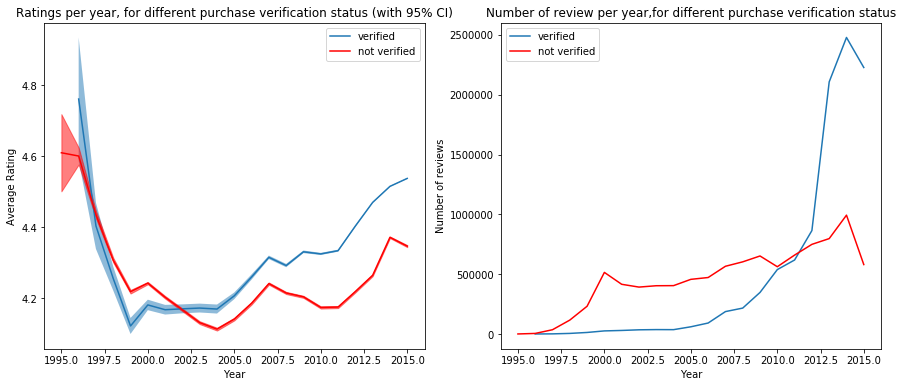

In [6]:
# Plot the results
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))

# Ax1: Ratings per year, for different purchase verification status (with 95% CI)
# Verified reviews in blue
ax1.plot(verified['year'], verified['avg'], label='verified')
ax1.fill_between(verified['year'], verified['avg'] - 1.96 * verified['std'] / np.sqrt(verified['count']), \
                                   verified['avg'] + 1.96 * verified['std'] / np.sqrt(verified['count']), alpha=0.5)

# Not verified reviews in red
ax1.plot(not_verified['year'], not_verified['avg'], color='red', label='not verified')
ax1.fill_between(not_verified['year'], not_verified['avg'] - 1.96 * not_verified['std'] / np.sqrt(not_verified['count']), \
                                       not_verified['avg'] + 1.96 * not_verified['std'] / np.sqrt(not_verified['count']), alpha=0.5, color='red')

ax1.set_xlabel('Year')
ax1.set_ylabel('Average Rating')
ax1.set_title('Ratings per year, for different purchase verification status (with 95% CI)')
ax1.legend()

#Ax2: Number of review per year,for different purchase verification status
ax2.plot(verified['year'], verified['count'], label='verified')
ax2.plot(not_verified['year'], not_verified['count'], label='not verified', color='red')

ax2.set_xlabel('Year')
ax2.set_ylabel('Number of reviews')
ax2.legend()
ax2.set_title('Number of review per year,for different purchase verification status')

plt.show()

We can clearly see, with a 95% confidence interval, that the average rating is higher for verified reviews in recent years. This is difficult to guess what could have caused it to change along the years, possibly one or more modifications in the condition to be a verified purchase. It would be good to ignore all unverified reviews, to have more reliable ratings. 

There is however a problem with that. By looking at the evolution of the number of reviews over the years (graph on the left just above), we realized that in the earliest years there are almost no verified reviews. This is probably due to the fact that this fonctionality was added quite late, or that maybe it used to be harder to be a verified review. Hence, we decided, despite the difference of rating, to keep all reviews, in order to avoid losing so much data for the earliest years.<br>
It is clear that a lot of data is mising in the 2000's if we limit ourselves to the verified reviews. From now on, we will use all the data

___
## 2.2.2 Analysis of `helpful_votes` and `total_votes` features
We want to see if the upvoted ratio on reviews in corrolated with the rating of the review.
Since the data set is very large and we cannot plot every point in pandas, we need to filter the data a little bit. To have representative amount of data on every helpful ratio, we decided to keep only the reviews with at least 10 votes, allowing for more precision in the helpful rate.

In [7]:
# Creating the helpful ratio: helpful_votes / total_votes
by_review = data.where('total_votes > 9').withColumn('helpful_ratio', data.helpful_votes / data.total_votes)
count = by_review.count()

# We will limit to at most ~100'000 data points in Pandas for pratical reasons
if(count > 100_000):
    by_review = by_review.sample(False, 100_000 / count, 123456)
    
# Data to panda and clean data
by_review_pandas = by_review.toPandas()
by_review_pandas = by_review_pandas[['helpful_ratio', 'star_rating']]
by_review_pandas["star_rating"] = pd.to_numeric(by_review_pandas["star_rating"])

# Group the reviews into 50 bins depending of their helpful_ratio
by_review_pandas = by_review_pandas.groupby([pd.cut(by_review_pandas['helpful_ratio'], bins=50, include_lowest=True)]) \
                                   .agg({'star_rating' : ['mean', 'count', 'std'], 'helpful_ratio' : 'mean'})

# Show the data
by_review_pandas.head(3)

star_rating                 helpful_ratio
                      mean count       std          mean
helpful_ratio                                           
(-0.002, 0.02]    2.579300  1343  1.599018      0.000527
(0.02, 0.04]      2.040293   273  1.490850      0.031717
(0.04, 0.06]      2.255682   528  1.555112      0.051123

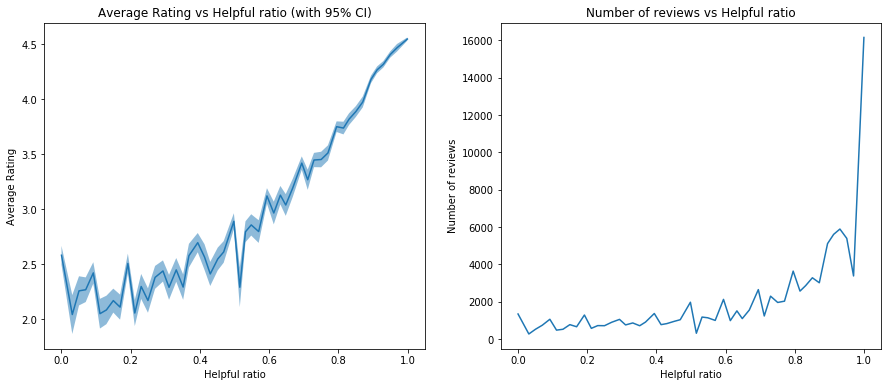

In [8]:
# Plot the results
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))
    
# First plot the average rating with its confidence interval
ax1.plot(by_review_pandas['helpful_ratio']['mean'], by_review_pandas['star_rating']['mean'])
ax1.fill_between(by_review_pandas['helpful_ratio']['mean'], by_review_pandas['star_rating']['mean'] - 1.96 * by_review_pandas['star_rating']['std'] / np.sqrt(by_review_pandas['star_rating']['count']), \
                                                            by_review_pandas['star_rating']['mean'] + 1.96 * by_review_pandas['star_rating']['std'] / np.sqrt(by_review_pandas['star_rating']['count']), alpha=0.5)
ax1.set_xlabel("Helpful ratio")
ax1.set_ylabel('Average Rating')
ax1.set_title('Average Rating vs Helpful ratio (with 95% CI)')
    
ax2.plot(by_review_pandas['helpful_ratio']['mean'], by_review_pandas['star_rating']['count'])
ax2.set_xlabel("Helpful ratio")
ax2.set_ylabel('Number of reviews')
ax2.set_title('Number of reviews vs Helpful ratio')
plt.show()

It would seem tendancy of users to upvote reviews is greatly dependent of the initial rating of that reviews.<br>
Furthermore, people tend to mostly give upvotes far more than downvotes as we can see the number of reviews being far greater when the helpful ratio is quite close to 1. But we cannot observe a real tendency between 0 and 0.8 which is difficult to interprete...

___
### 2.2.3 Analysis the number of reviews per product
We want here to see if there is any trend going on between the total number of reviews on a product and the rating of that product. So first we will group the data per product and count the number of reviews and the average rating.

In [9]:
# Group by product_id, get reviews count and average star_rating
reviews_per_product = data.groupby('product_id').agg(f.avg('star_rating'), f.count('review_id'))
    
# Rename columns
reviews_per_product = reviews_per_product.withColumnRenamed('count(review_id)', 'n_reviews') \
                        .withColumnRenamed('avg(star_rating)', 'rating')

print('Total number of products: ' + str(reviews_per_product.count()))

Total number of products: 3417210


Since we want to draw some plots, we have to convert our data to a pandas dataframe, However, we currently have too much data for pandas, so we decided to only keep reviews with more than 2 reviews. It is kind of an arbitrary number, but it is reasonable to assume that the average rating of products with a small amount of reviews might not be that reliable as an indication of the true quality of the product. If after some more advanced analysis we realized that those reviews might actually be important, we may do a subsample of the data instead, and use that for our plots.

In [10]:
reviews_per_product = reviews_per_product.where('n_reviews > 2')
print('Total number of products with more than 2 reviews: ' + str(reviews_per_product.count()))

Total number of products with more than 2 reviews: 1292594


In [11]:
by_product = reviews_per_product.toPandas()
by_product.head(3)

,product_id,rating,n_reviews
0,1940689007,4.623656,279
1,1884527388,4.687500,256
2,0736434364,5.000000,4


Now, we will plot the average rating compared to the number of reviews. We group on the number of reviews, but this time we use logarithmic bins for a nicer plot.

In [12]:
# Group the data into logarithmic bins and get statistical information
grouped_product_n_reviews = by_product.groupby([pd.cut(by_product['n_reviews'], bins=np.logspace(1, 3), include_lowest=True)]) \
                                      .agg({'rating' : ['mean', 'count', 'std'], 'n_reviews' : 'mean'})
grouped_product_n_reviews.head(3)

rating                   n_reviews
                      mean  count       std       mean
n_reviews                                             
(9.999, 10.985]   4.369884  40171  0.554550  10.000000
(10.985, 12.068]  4.358492  62166  0.547209  11.459142
(12.068, 13.257]  4.355776  24432  0.532613  13.000000

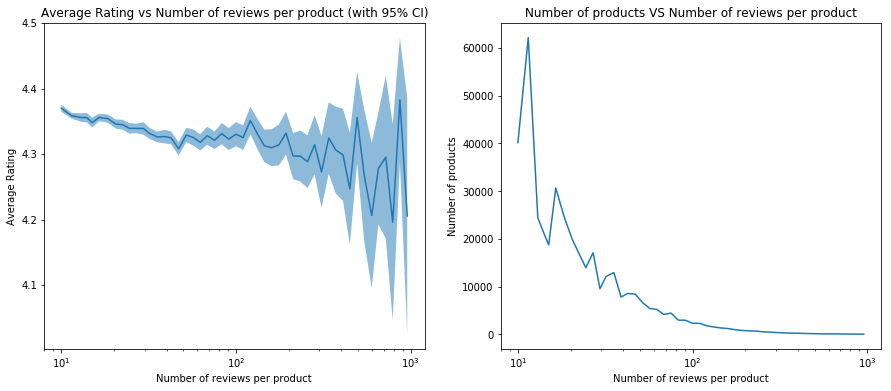

In [13]:
# Plot the results
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))
    
# First plot the average rating with its confidence interval
ax1.plot(grouped_product_n_reviews['n_reviews']['mean'], grouped_product_n_reviews['rating']['mean'])
ax1.fill_between(grouped_product_n_reviews['n_reviews']['mean'], grouped_product_n_reviews['rating']['mean'] - 1.96 * grouped_product_n_reviews['rating']['std'] / np.sqrt(grouped_product_n_reviews['rating']['count']), \
                                            grouped_product_n_reviews['rating']['mean'] + 1.96 * grouped_product_n_reviews['rating']['std'] / np.sqrt(grouped_product_n_reviews['rating']['count']), alpha=0.5)
ax1.set_xscale('log')
ax1.set_xlabel('Number of reviews per product')
ax1.set_ylabel('Average Rating')
ax1.set_title('Average Rating vs Number of reviews per product (with 95% CI)')
    
ax2.plot(grouped_product_n_reviews['n_reviews']['mean'], grouped_product_n_reviews['rating']['count'])
ax2.set_xscale('log')
ax2.set_xlabel('Number of reviews per product')
ax2.set_ylabel('Number of products')
ax2.set_title('Number of products VS Number of reviews per product')
plt.show()

There seem to be a trend between the two, but as the number of reviews per product increases, we have less and less data and the confidence interval becomes larger. This makes sense, as we can expect the number of reviews to be highly positively correlated with the number of sales. It is quite intuitive that only few products are very popular and many products are not so successful.

So we can observe for sure a descending trend in the average rating between 3 and ~100 number of reviews per product (of about 0.05 stars, which is not negligable with so much data) but any value after that becomes too uncertain to conclude anything.

___
### 2.2.4 Analysis of Time Based Features

Here, we will try to see if the time the review was posted has any influence. We will compare the data against the average rating, and the number of ratings. For the date, we will look at the year, the month, the day of the month and the day of the week.

We create a single function, that will take the data and the 'type of time', and plot two graphs, one with the average rating, and one with the number of ratings. For the average graph, we will also plot a 95% condidence interval on the mean, using the central limit theorem.

In [14]:
def get_time_analysis(data, time_name):
    time_types = {'month' : month('date'), 'year' : year('date'), 'dayofweek' : dayofweek('date'), 'dayofmonth' : dayofmonth('date')}
    group_function = time_types[time_name]
    
    # Groupby the time type, aggregate usefull columns, and sort by time
    data_bytime = data.groupby(group_function).agg(f.avg('star_rating'), f.count('review_id'), f.stddev('star_rating')).withColumnRenamed('avg(star_rating)', 'rating').withColumnRenamed('stddev_samp(star_ratinng)', 'std_rating').withColumnRenamed(time_name + '(date)', time_name)
    data_bytime_sorted = data_bytime.sort(time_name)
    
    by_time_pd = data_bytime_sorted.toPandas()
    
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))
    
    # First plot the average rating with it's condidence interval
    ax1.plot(by_time_pd[time_name], by_time_pd['rating'])
    ax1.fill_between(by_time_pd[time_name], by_time_pd['rating'] - 1.96 * by_time_pd['stddev_samp(star_rating)'] / np.sqrt(by_time_pd['count(review_id)']), \
                                            by_time_pd['rating'] + 1.96 * by_time_pd['stddev_samp(star_rating)'] / np.sqrt(by_time_pd['count(review_id)']), alpha=0.5)
    ax1.set_xlabel(time_name)
    ax1.set_ylabel('Average Rating')
    ax1.set_title('Average Rating vs ' + time_name)
    
    ax2.plot(by_time_pd[time_name], by_time_pd['count(review_id)'])
    ax2.set_xlabel(time_name)
    ax2.set_ylabel('Number of reviews')
    ax2.set_title('Number of reviews vs ' + time_name)
    plt.show()
    

We will give this function a table that has a rating and a review date as its columns

In [15]:
by_time = data.select(data['star_rating'],to_date(data['review_date'], 'yyyy-MM-dd').alias('date'), data['review_id'])
_ = by_time.persist()

Let's run it on different "types of time"

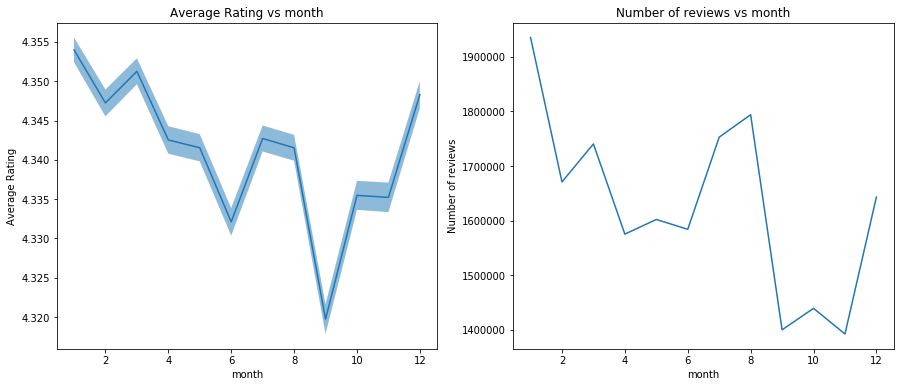

In [16]:
get_time_analysis(by_time, 'month')

We can observe that the confidence bands for the average rating by month are quite tight. This allows us to draw conclusions with confidence. For the total number of reviews, however, we can not draw confidence bands. The number of reviews seems to have a general correlation with holidays. There is roughly a peak in summer and one in winter. We attribute this to the fact that people have more time then. Note however that the reviews we have range from may 1996 to july 2014. The lower values in the fall might also be partialy related to the fact the we have the data for fall 2014, but this alone shouldn't have that much influence over al the years.

We also see that the ratings are higher in hollyday season. This we attribute to the people being happier then.

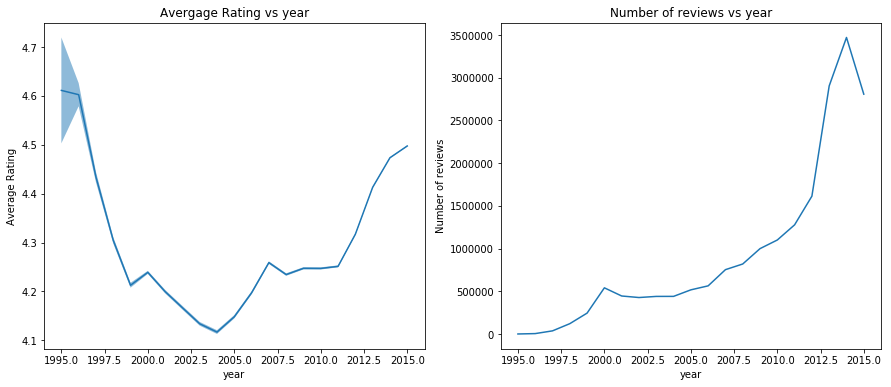

In [25]:
get_time_analysis(by_time, 'year')

Again, the confidence bands are very tight for the rating, which is nice for drawing conclusions. We can see that the confidance band widens for early years, here there are less reviews. We clearly see a decrease in the years up untill ~2003 in the ratings. Afterwards the ratings increase. We will check if this effect is present in datasets across countries and product types in the next milestone. We will have to do research in order to find out wether amazon changed their rating system somehow or why this effect may occur. The number of reviews per year is clearly increasing, which is not surprising since amazon has been growing steadily. We observe a slight decrease after the year 2000, this may be attributed to a decrease in interest in internet companies after the dotcom bubble. The last drop around 2014-2015 is simply due to the missing data after july 2014. 

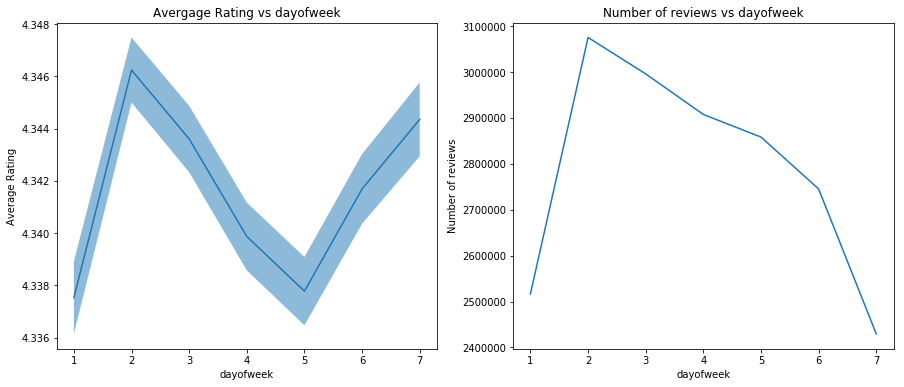

In [26]:
get_time_analysis(by_time, 'dayofweek')

We can see that here, the confidence bands are wider. Notably, we have a spike in ratings on monday, which is surprising as we would expect people to not be the happiest on monday. The number of ratings starts high at the beginning of the week, and then steadily decreases until the weekend where it is at its lowest point. We may assume that people use / test their new products during the weekend, and give it a rating the following week after, mainly on monday because they don't have the motivation to work. 

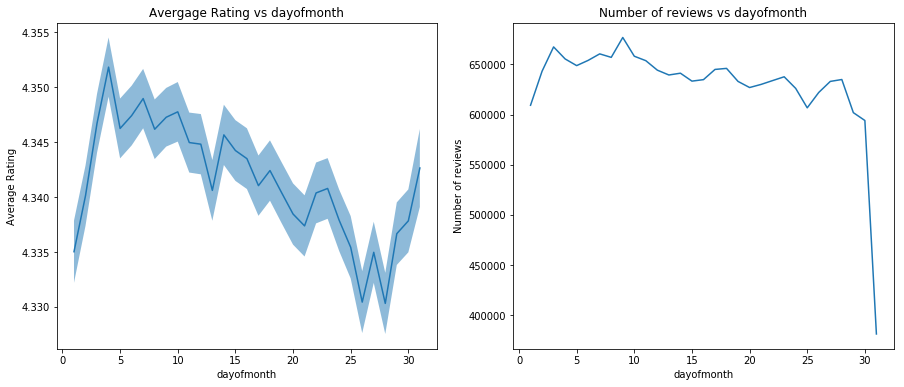

In [27]:
get_time_analysis(by_time, 'dayofmonth')

For the day of the month, the confidence bands are almost too big to draw significant conclusions. We could however argue that people usually receive their salary at the end of the month, therfore are more happy and give better ratings in the following days, with their happiness decreasing until the next payday. The Number of reviews is very low on the 31. This is not something worth interpreting, as almost all months have at least 30 days, but only a few have 31. The slight decrease in the number of reviews over the month might be connected to the previous argument of payday happiness, where people might spend more money to buy products on amazon at the beggining of the month, and hence give more reviews. 

___
## 2.3 Text analysis

Another feature that may give us a hint on the rating is the review's text. A method that comes to mind would be to analyse the text with natural language processing models, especially sentiment analysis. But this analysis would not bring new insights, if we were to find a positive correlation. It would seem fairly intuitive that a more positive review will come with a higher rating. Additionnaly, these methods would be cumbersome to implement with spark and use too much processing power.<br>
We decided to go with features that are easier to extract. We chose to use text length. The reasoning would be that there is not much to say if the product is perfect, but one can explain at length why the product is not good.

In [17]:
group_by_3 = udf(lambda x : 0 if x is None else 3*int(x / 3))
group_by_100 = udf(lambda x : 0 if x is None else 100*int(x / 100))

# Titles grouped in bins of 3 characters, body grouped in bins of 100 characters
by_review_length = data.select(data['star_rating'], \
                               group_by_3(length(data['review_headline'])).alias('title_length'), \
                               group_by_100(length(data['review_body'])).alias('body_length'), \
                                      data['review_id'])
by_review_length.show(3)

+-----------+------------+-----------+--------------+
|star_rating|title_length|body_length|     review_id|
+-----------+------------+-----------+--------------+
|          5|           9|          0| RJOVP071AVAJO|
|          5|          60|        300|R1ORGBETCDW3AI|
|          5|          12|          0| R7TNRFQAOUTX5|
+-----------+------------+-----------+--------------+
only showing top 3 rows



We first take a look a the title length

In [18]:
# We noticed that title_length is always between [0, 128] characters long
by_title_length = by_review_length.where('title_length <= 128').groupby('title_length').agg(f.avg('star_rating'), f.count('review_id'), f.stddev('star_rating')) \
                    .withColumnRenamed('avg(star_rating)', 'rating') \
                    .withColumnRenamed('stddev_samp(star_rating)', 'std_rating') \
                    .withColumnRenamed('count(review_id)', 'count')
by_title_length_pd = by_title_length.toPandas()

In [19]:
by_title_length_pd["title_length"] = pd.to_numeric(by_title_length_pd["title_length"])
by_title_length_pd = by_title_length_pd.sort_values(by='title_length')

In [20]:
by_title_length_pd.head(5)

,title_length,rating,count,std_rating
8,0,3.754974,22651,1.216388
6,3,4.168631,298533,1.269220
17,6,4.066139,647150,1.447245
30,9,4.603924,3332741,0.839305
36,12,4.279377,1474436,1.201970


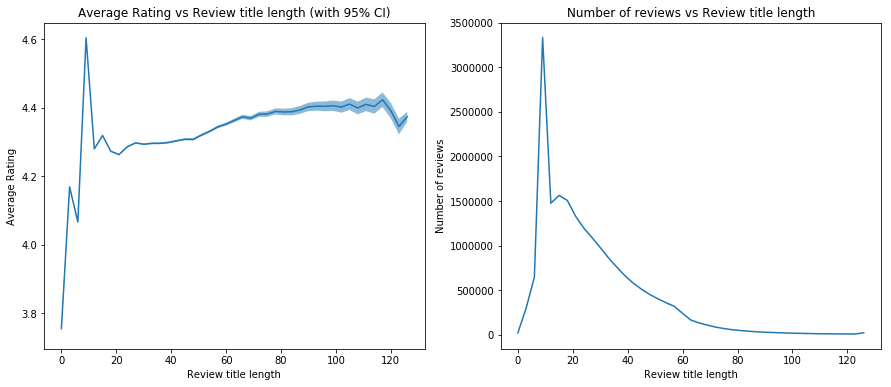

In [21]:
# Plot the results
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))
    
# First plot the average rating with its confidence interval
ax1.plot(by_title_length_pd['title_length'], by_title_length_pd['rating'])
ax1.fill_between(by_title_length_pd['title_length'], by_title_length_pd['rating'] - 1.96 * by_title_length_pd['std_rating'] / np.sqrt(by_title_length_pd['count']), \
                                            by_title_length_pd['rating'] + 1.96 * by_title_length_pd['std_rating'] / np.sqrt(by_title_length_pd['count']), alpha=0.5)
ax1.set_xlabel('Review title length')
ax1.set_ylabel('Average Rating')
ax1.set_title('Average Rating vs Review title length (with 95% CI)')
    
ax2.plot(by_title_length_pd['title_length'], by_title_length_pd['count'])
ax2.set_xlabel('Review title length')
ax2.set_ylabel('Number of reviews')
ax2.set_title('Number of reviews vs Review title length')
plt.show()

We have a huge peak for reviews with a title length of aproximatly 10 characters. This might be because a lot of people that liked their products put simple titles such as "very good", "I recommand", "best product", and so on. Reviews with very small titles have lower grades, maybe people that don't like product don't care about the title and just put the negative comment, but this there is a very low number of those reviews it is harder to tell with good confidence. 

Overall however, we see that the average rating increases quite a lot for longer titles (more than 0.1 stars), probably because people that liked the product take some time to make good titles that might catch the attention of other people. 

For the number of reviews, this result is expected. Most of the people make short title, whith very few making extremly short titles (hard to do a title in 3 letters), and few make very long title (Most people will write their opinion in the review body instead).

We will look deeper at reviews with a title of length 10.

In [82]:
data_10_char = data.select(data['review_headline'],length(data['review_headline']).alias('title_length'),data['review_id'])
data_10 = data_10_char.where('title_length == 10').groupby('review_headline').agg(f.count('review_id'))\
                            .withColumnRenamed('count(review_id)', 'count').where('count>5')

In [86]:
d = data_10.toPandas()
d = d.sort_values('count',ascending=False).reset_index(drop=True)
d.head(6)

,review_headline,count
0,Five Stars,1380977
1,Four Stars,226379
2,Great book,62192
3,Great Book,53497
4,great book,25645
5,Excellent!,16354


This confirms our intuition. Most of the people that liked the product can put a simple adjective / the number of stars, to quickly say what they think. For negative reviews, this would be harder, at least if you want to give a constructive review.

Now, for the body length

In [45]:
# We noticed that body_length is almost always between [0, 10000] characters long, after which there is almost no data which creates a huge amont of noise
by_body_length = by_review_length.where('body_length <= 10000').groupby('body_length').agg(f.avg('star_rating'), f.count('review_id'), f.stddev('star_rating')) \
                    .withColumnRenamed('avg(star_rating)', 'rating') \
                    .withColumnRenamed('stddev_samp(star_rating)', 'std_rating') \
                    .withColumnRenamed('count(review_id)', 'count')
by_body_length_pd = by_body_length.toPandas()

In [46]:
by_body_length_pd["body_length"] = pd.to_numeric(by_body_length_pd["body_length"])
by_body_length_pd = by_body_length_pd.sort_values(by='body_length')

In [47]:
by_body_length_pd.head(5)

,body_length,rating,count,std_rating
20,0,4.594046,2742067,0.898993
34,100,4.473407,3907278,1.027661
8,200,4.385682,2305836,1.128465
30,300,4.339753,1739661,1.169139
83,400,4.302999,1369953,1.192641


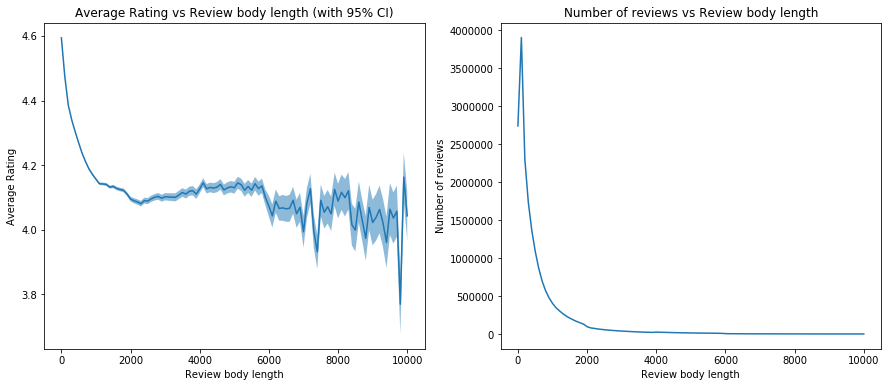

In [50]:
# Plot the results
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))
    
# First plot the average rating with its confidence interval
ax1.plot(by_body_length_pd['body_length'], by_body_length_pd['rating'])
ax1.fill_between(by_body_length_pd['body_length'], by_body_length_pd['rating'] - 1.96 * by_body_length_pd['std_rating'] / np.sqrt(by_body_length_pd['count']), \
                                            by_body_length_pd['rating'] + 1.96 * by_body_length_pd['std_rating'] / np.sqrt(by_body_length_pd['count']), alpha=0.5)
ax1.set_xlabel('Review body length')
ax1.set_ylabel('Average Rating')
ax1.set_title('Average Rating vs Review body length (with 95% CI)')

    
ax2.plot(by_body_length_pd['body_length'], by_body_length_pd['count'])
ax2.set_xlabel('Review body length')
ax2.set_ylabel('Number of reviews')

ax2.set_title('Number of reviews vs Review body length')
plt.show()

For the body lenght however we see that the result is completly different. A short review body generaly corresponds to a higher rating, whereas a long review coresponds to a lower rating. It probably is because there is not always much to say for excellent products, whereas you can describe a lot of negative points for the less good products. That trend is very clear between 0 and 2000 characters, with a huge drop of more than 0.5 stars, but for longer reviews, it is harder to conclude anything since the confidence interval is much larger, and we can see a lot of noise. 

___
## 2.4 Comparaison betwen countries

In this part, we want to see if there are any differences between the way people rate articles in differents countries.

To be able to correcly compare ratings between countries, we will have to limit our dataset to products that are available in both regions. Moreover, we will only keep reviews given during the same time period, since we saw earlier that the year of the review had quite a big impact on the rating. 

> e.g. If for a given article we have reviews from 2001 to 2015 in the US, but only from 2005 to 2015 in the UK, we will discard all reviews in the us before 2005.

We will first do pairwise comparaisons, since it is the way we will have the most common data. We might also do a comparaison between all 5 available countries, but the remaining number of reviews might be limited.

For milestone 2, we will only study the difference between the US and UK, but the process will be the same for other pairs of countries.

---

First, we will open the datasets, as done earlier in this notebook

In [55]:
FILE_NAME_US = 'amazon_reviews_multilingual_US_v1_00.tsv.gz'
FILE_NAME_UK = 'amazon_reviews_multilingual_UK_v1_00.tsv.gz'

In [56]:
data_us = spark.read.option("sep", "\t").option("header", "true").csv(DATA_PATH + FILE_NAME_US)
data_uk = spark.read.option("sep", "\t").option("header", "true").csv(DATA_PATH + FILE_NAME_UK)

WIll we now use the group_by_product function, which will limit the data to one entry per product, gibing us many informations about each product. One of them is the time of the first review for this product.

In [61]:
def group_by_product(data):
    avg_stars = data.groupby('product_id', 'product_title').agg(f.avg('star_rating'), 
                                                                f.count('review_id'), 
                                                                f.min(to_date(data['review_date'], 'yyyy-MM-dd')),
                                                                f.stddev('star_rating'))
    avg_stars.persist()
    avg_stars = avg_stars.withColumnRenamed('count(review_id)', 'n_reviews') \
                        .withColumnRenamed('avg(star_rating)', 'rating') \
                        .withColumnRenamed("min(to_date(`review_date`, 'yyyy-MM-dd'))", 'first_date') \
                        .withColumnRenamed('stddev_samp(star_rating)', 'std_rating')
    

    return avg_stars

In [63]:
avg_us = group_by_product(data_us)
avg_uk = group_by_product(data_uk)

_ = avg_us.persist()
_ = avg_uk.persist()

# To be able to differenciate columns after a later join
us = avg_us.alias("us")
uk = avg_uk.alias("uk")

We can join the products from US and UK, with an inner join, so we only have common products

In [67]:
us_uk = us.join(uk, f.col('us.product_id') == f.col('uk.product_id'))

We can see here some of the entries of the us_uk table, were the left-hand side columns correspond to the US data, and the right-hand side columns to the UK data

|product_id|       product_title|            rating|n_reviews|first_date|        std_rating|product_id|       product_title|            rating|n_reviews|first_date|        std_rating|
|----------|--------------------|-----------------|---------|-------------|-----------|----------|------------------|----------|--------------------|------|---------|-------------|-----------|----------|------------------|
|0060557818| Neverwhere: A Novel| 4.149305555555555|      288|2003-10-28| 1.136318189708195|0060557818|          Neverwhere| 4.666666666666667|        3|2005-03-18|0.5773502691896258|
|0099416921|             Venetia|               5.0|        2|2003-08-19|               0.0|0099416921|             Venetia|               5.0|        3|2001-03-18|               0.0|
|0099428385|I Don't Know How ...| 4.666666666666667|        3|2011-05-02|0.5773502691896258|0099428385|I Don't Know How ...|3.7761194029850746|       67|2003-05-01| 1.444119691194815|

We will use this table to get for each product the earliest date reviews were available in both countries 

In [70]:
latest_date = us_uk.select(f.col('us.product_id'),greatest(f.col('us.first_date'), f.col('uk.first_date'))) \
                        .withColumnRenamed("product_id", "id").withColumnRenamed("greatest(us.first_date, uk.first_date)", 'latest_date')

Again, here is an excerpt of the `latest_date` table, where `latest_date` is the date starting when the product `id` had received reviews in both countries

|        id|latest_date|
|----------|-----------|
|0060920432| 2000-02-11|
|0140072187| 2015-08-12|


We can now, for the US, and the UK, only keep reviews that were writen when the article was available in both countries

In [71]:
us_common_with_date = data_us.join(latest_date, data_us['product_id'] == latest_date['id'])
us_common_reviews = us_common_with_date.where('review_date >= latest_date')
_ = us_common_reviews.persist()

uk_common_with_date = data_uk.join(latest_date, data_uk['product_id'] == latest_date['id'])
uk_common_reviews = uk_common_with_date.where('review_date >= latest_date')
_ = uk_common_reviews.persist()

And now that we have reduced our dataset to only reviews of articles that are common between the uk and us, and for the same time period, we can get some statistics for each product

In [72]:
common_us_avg = group_by_product(us_common_reviews)
common_uk_avg = group_by_product(uk_common_reviews)

Here is an excerpt of the `common_us_avg` table

|product_id|       product_title|            rating|n_reviews|first_date|        std_rating|
|----------|--------------------|-----------------|---------|-------------|-----------|----------|------------------|
|0060557818| Neverwhere: A Novel|  4.15034965034965|      286|2006-01-02|1.1371478094221354|
|0099416921|             Venetia|               5.0|        2|2003-08-19|               0.0|
|0099428385|I Don't Know How ...| 4.666666666666667|        3|2011-05-02|0.5773502691896258|
|0141038225|Antifragile: Thin...| 4.666666666666667|        3|2013-09-30|0.5773502691896258|

Here is an excerpt of the `common_uk_avg` table

|product_id|       product_title|            rating|n_reviews|first_date|        std_rating|
|----------|--------------------|-----------------|---------|-------------|-----------|----------|------------------|
|0060557818|          Neverwhere| 4.666666666666667|        3|2005-03-18|0.5773502691896258|
|0099416921|             Venetia|               5.0|        1|2004-10-07|               NaN|
|0099428385|I Don't Know How ...| 3.909090909090909|       22|2011-09-24|1.3059968245090434|
|0141038225|Antifragile: Thin...|3.5714285714285716|       21|2013-11-11| 1.468721504282843|

Now that our data has been cleaned, we can try and see if there is a difference between the ratings from the US and the UK. 

In [76]:
us_pd = common_us_avg.toPandas()
uk_pd = common_uk_avg.toPandas()

In [79]:
us_pd['rating'].mean()

4.350546334216427

In [80]:
uk_pd['rating'].mean()

4.419649728393554

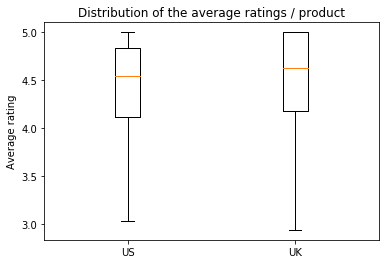

In [77]:
plt.boxplot([us_pd['rating'], uk_pd['rating']], 0, sym='',autorange=True, labels=['US', 'UK'])
plt.title('Distribution of the average ratings / product')
plt.ylabel('Average rating')
plt.show()

We see that the median average rating is lower in the US than in the UK, but the confidence intervals are quite large so we should be careful when using this information.

## 2.5 Herding behavior

One of the bias that might effect the ratings is what is called the Herding Behavior. Basically, for the same product, depending on the first review given to it, other reviews will vary. If the first review is very positive, other reviewers might have a tendency to also put a higher grade. The same is true for a first negative rating. If we want to make some analysis and give some hypotheses about this, we will need enough data, i.e. enough common products with a non negligable rating difference between the two countries. We have 29507 entries in the `us_uk`, which isn't that much compared to the size of previous data, but we think it is still enough to see if this effect is indeed real.

We will look at this effect in depth for milestone 3, but apparently we will have enough data to observe a behavior if it indeed exists. For common articles in every countries, we will get the first review and compare it to the average review. We may correct some eventual bias due to the rating difference between countries.

## 2.6 Bias Correction

With all these information about the reviews, we will be able to create our bias correction algorithm. We now know the product rating is correlated to other variables, and this will be taken into account. A first attempt at designing this algorithm can be found in the `README`.

## 2.7 Conclusion

We see that many variables depends on the grade, at least for the books. For the third milestone, we will extend this analysis to other categories of product, and see if our observations will be consistent or not. We will also perform analysis between other countries, not only the US and UK. 

We might also try to analyze other features that we for now didn't consider useful, but we think that the one we analyzed are the most important ones.